## Instalando Tensorflow

In [1]:
# Instalação das bibliotecas necessárias
%pip install tensorflow
%pip install gensim
%pip install nltk
%pip install seaborn
%pip install keras
%pip install --upgrade tensorflow
%pip install scikeras[tensorflow]


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install --upgrade tensorflow


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
from gensim.models import Word2Vec
from nltk.stem import RSLPStemmer
import re
import os
import unicodedata
from zipfile import ZipFile
import nltk
import xml.etree.ElementTree as ET
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Carregamento dos Dados e Pré-processamento

### Carregar e descompactar os arquivos

In [4]:


def unzip(path, pathFolder):
    """
    Descompacta a base de dados de notícias.
    
    Args:
    path (str): Caminho para o arquivo zip.
    pathFolder (str): Caminho para a pasta onde os arquivos serão extraídos.
    """
    # Abre o arquivo zip para leitura
    with ZipFile(path, 'r') as z:
        # Verifica se a pasta de destino já existe
        if not os.path.isdir(pathFolder):
            # Extrai todos os arquivos para a pasta de destino
            z.extractall(pathFolder)
        else:
            print("Os arquivos já foram descompactados.")

# Caminho dos arquivos extraídos do Kaggle
path_dataset = r'files\classificao-de-notcias.zip'
path_db = r'db'

# Caminho dos arquivos que serão utilizados para a atividade
path_train = r'db\arquivos_competicao\arquivos_competicao\train.csv'
path_pred = r'db\arquivos_competicao\arquivos_competicao\test.csv'
path_news = r'db\arquivos_competicao\arquivos_competicao\news'

# Antes de descompactar os arquivos, valida se já foram descompactados antes
if not os.path.isdir(path_news):
    # Verifica se o arquivo zip existe
    if os.path.isfile(path_dataset):
        unzip(path_dataset, path_db)
    else:
        print(f"Arquivo não encontrado: {path_dataset}")
else:
    print("Os arquivos já foram descompactados.")



Os arquivos já foram descompactados.


In [ ]:
def criar_diretorios(caminho):
    # Extrai o diretório do caminho fornecido
    diretorio = os.path.dirname(caminho)
    
    # Cria os diretórios se eles não existirem
    if not os.path.exists(diretorio):
        os.makedirs(diretorio)
        print(f"{diretorio} criado com sucesso")
    else:
        print(f"{diretorio} já existe")
        
    return caminho

# Carregamento dos dados de treino e teste
Carregamos os arquivos CSV de treino e teste, ordenando pela coluna ID.


In [5]:
# Carregamento dos dados de treino e teste
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_pred)

# Ordena os dataframes df_train e df_test pela coluna ID
df_train = df_train.sort_values(['ID'])
df_test = df_test.sort_values(['ID'])

# Extração dos dados XML

- A função extract_xml_text extrai o texto e o título dos arquivos XML. Atualizamos os dataframes df_train e df_test com esses dados.


In [6]:
# Definindo a função para extração dos dados XML 
def extract_xml_text(path_xml):
    """
    Extrai o texto e o título dos arquivos XML.

    Args:
    path_xml (str): Caminho para o arquivo XML.

    Returns:
    tuple: Contém o título e o texto do arquivo XML.
    """
    tree = ET.parse(path_xml)
    root = tree.getroot()
    
    # Extraindo o título
    headline = root.find('headline').text if root.find('headline') is not None else ''
    
    # Extraindo os parágrafos
    paragraphs = root.findall('.//p')
    text = ' '.join([p.text for p in paragraphs if p.text is not None])

    return headline, text

# Processando os arquivos XML e atualizando o dataframe df_train
for idx in df_train.index:
    file = df_train.at[idx, 'ID']
    path_xml = os.path.join(path_news, file)
    titulo, texto = extract_xml_text(path_xml)
    df_train.at[idx, 'TITULO'] = titulo
    df_train.at[idx, 'TEXTO'] = texto

# Reorganiza o dataframe com as colunas desejadas
df_train = df_train[['ID', 'TITULO', 'TEXTO', 'Class']]

# Processando os arquivos XML e atualizando o dataframe df_test
for idx in df_test.index:
    file = df_test.at[idx, 'ID']
    path_xml = os.path.join(path_news, file)
    titulo, texto = extract_xml_text(path_xml)
    df_test.at[idx, 'TITULO'] = titulo
    df_test.at[idx, 'TEXTO'] = texto

# Reorganiza o dataframe com as colunas desejadas
df_teste = df_test[['ID', 'TITULO', 'TEXTO']]


# Definindo funçãio de tratamento de texto

utilizando função de tratamento de texto para remover tags html
- Removendo stopwords com `nltk.corpus.stopwords.words`
- Utilizando método de stemização para extrair os radicais das palavras contidas nas mensagens de texto com `stemmer_method = RSLPStemmer()`

In [7]:
def preprocessing_portuguese(text, stemming=False, stopwords=False):
    text = text.lower()
    nltk.download('rslp')
    nltk.download('stopwords')
    nfkd_form = unicodedata.normalize('NFKD', text)
    text = u"".join([c for c in nfkd_form if not unicodedata.combining(c)])
    text = re.sub('<[^<>]+>', " ", text)
    text = re.sub('(http|https)://[^\s]*', "<URL>", text)
    text = re.sub('[^\s]+@[^\s]+', "<EMAIL>", text)
    text = re.sub('[^A-Za-z0-9]+', " ", text)
    text = re.sub('[0-9]+.[0-9]+', "NUMERO", text)
    text = re.sub('[0-9]+,[0-9]+', "NUMERO", text)
    text = re.sub('[0-9]+', "NUMERO", text)
    text = ' '.join(text.split())
    words = text.split()[0:200]
    if stopwords:
        words = [w for w in words if not w in nltk.corpus.stopwords.words('portuguese')]
    if stemming:
        stemmer_method = RSLPStemmer()
        words = [stemmer_method.stem(w) for w in words]
    words = [w for w in words if len(w) > 1]
    text = " ".join(words)
    return text

# Aplicando a função e enconding para campo target

- utiliando função  preprocessing_portuguese definida anteriormente para tratar os campos de mensagens
- usando  labelEncoder para codificar o campo target para valores 0, 1, 2 e 3 com o intuito de representar os elementos da classe em números

In [8]:


df_train['TEXTO'] = df_train['TEXTO'].apply(lambda x: preprocessing_portuguese(x, stemming=True, stopwords=True))
df_test['TEXTO'] = df_test['TEXTO'].apply(lambda x: preprocessing_portuguese(x, stemming=True, stopwords=True))
le = LabelEncoder()
df_train['Class'] = le.fit_transform(df_train['Class'])


[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\vitor

### Usando função de split para dividir o dataset de treino em campos de Data e Target

Usando 20 porcento do dataset como teste devido a distribução das classes no dataset de treino
(algumas classes possuem menos elementos do que as outras)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_train['TEXTO'],
                                                    df_train['Class'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df_train['Class'])


X_pred = df_test['TEXTO']


# Definindo newDatasetTrain

- esse vetor será utilizado para treinar as embeddings com nossa base de treino

In [10]:
newDatasetTrain = []
for msg in df_train['TEXTO']:
    newDatasetTrain.append( msg.split() )

print("Primeira mensagem de texto: ")
print( newDatasetTrain[0] )

Primeira mensagem de texto: 
['futur', 'bdpotznumer', 'dez', 'numer', 'numer', 'vs', 'numer', 'fech', 'anteri', 'futur', 'bon', 'dez', 'numer', 'mffznumer', 'numer', 'vs', 'numer', 'fech', 'anteri', 'lisbo', 'editor', 'numer', 'numer', 'reut', 'limited', 'numer']


In [11]:
dataset_train, dataset_test = X_train, X_test
Y_train, Y_test = y_train, y_test

dstaset_pred = X_pred

In [12]:
print('Qtd. dados de treinamento: %d (%1.2f%%)' %(dataset_train.shape[0], (dataset_train.shape[0]/df_train.shape[0])*100) )
print('Qtd. de dados de teste: %d (%1.2f%%)' %(dataset_test.shape[0], (dataset_test.shape[0]/df_train.shape[0])*100) )

Qtd. dados de treinamento: 2224 (79.97%)
Qtd. de dados de teste: 557 (20.03%)


# Treinando modelo de embeddings

Treinamos o modelo de embeddings conforme os dados presentes na coluna de texto  em df_train que possui os dados tratados de train.csv
obtivemos um vocabulário relativamente enchuto, no entanto normalizar o dataset replicando notícias com classes de menor indicência obtivemos dificuldade
no treinamento do modelo. Ao que parece foi difícil lidar com o loss ao ajustar ao parâmetro, logo foi optado por utilizar os dados de treino da forma com
que foram passados mesmo.


- vector_size: Tamanho do vetor de embedding.
- window: Tamanho da janela de contexto.
- min_count: Frequência mínima para uma palavra ser considerada no treinamento.
- workers: Número de threads a serem usadas no treinamento.

In [13]:
from gensim.models import Word2Vec

# Treinando o modelo Word2Vec com suas mensagens de texto
embedding_model = Word2Vec(sentences=newDatasetTrain, vector_size=200, window=5, min_count=1, workers=4)

vocabSize = len(embedding_model.wv)
print("Tamanho do vocabulário do modelo: ", vocabSize)

Tamanho do vocabulário do modelo:  4599


In [14]:
print(Y_test)

2581    3
2181    3
2690    3
1867    3
355     3
       ..
2291    1
803     3
2363    3
1130    3
1398    3
Name: Class, Length: 557, dtype: int32


## Obtendo vetores das palavras

### A função getDocvector converte os textos em vetores de embeddings usando o modelo Word2Vec.

- model: Modelo Word2Vec treinado.
- doc: Documento a ser convertido.
- maxLength: Comprimento máximo do documento.

In [15]:
def getDocvector(model, doc, maxLength = 200):
    """
    Obtem o vetor de cada palavra de um documento e calcula um vetor medio
    """

    ########################## COMPLETE O CÓDIGO AQUI  ########################

    firstWord = model.wv.index_to_key[0]
    dimEmbedding = model.wv[firstWord].shape[0]

    wordVecs = []

    for i in range(maxLength):

      vecZeros = np.zeros( dimEmbedding )
      wordVecs.append( vecZeros )

      if i<len(doc):

          try:
            wordVecs[i] = model.wv[ doc[i] ]
          except:
            pass

    # converte a lista em matriz
    wordVecs = np.array(wordVecs)

    ##########################################################################

    return wordVecs


In [16]:
X_train_array = []
for doc in X_train:
    X_train_array.append( getDocvector(embedding_model, doc.split(), maxLength = 200) )
    
X_test_array = []
for doc in X_test:
    X_test_array.append( getDocvector(embedding_model, doc.split(), maxLength = 200) )
    
X_train_array = np.array(X_train_array)
X_test_array = np.array(X_test_array)    
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)    
    
print("Dimensao de X_train: ", X_train_array.shape)
print("Dimensao de X_test: ", X_test_array.shape)




Dimensao de X_train:  (2224, 200, 200)
Dimensao de X_test:  (557, 200, 200)


# Treinamento do Modelo LSTM
### Configuração do Modelo LSTM
Configuramos um modelo LSTM com uma camada intermediária LSTM e uma camada de saída Dense com ativação softmax e sparse_categorical_crossentropy para problemas multiclasse.

- dimInput: Dimensão da entrada.
- units: Número de unidades na camada LSTM.
- activation: Função de ativação da camada Dense.

Foi testado a inserção de camadas de drop out com o intuito de evitar o overfitting

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Obtém a primeira palavra do modelo de embedding e define a dimensão do embedding
firstWord = embedding_model.wv.index_to_key[0]
dimEmbedding = embedding_model.wv[firstWord].shape[0]

# Define a dimensão de entrada
dimInput = (200, dimEmbedding)

# Cria o modelo sequencial
model = tf.keras.Sequential()

# Adiciona a camada LSTM bidirecional
model.add(tf.keras.Input(shape=dimInput))  # Define explicitamente a forma da entrada
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
    units=128,  # Número de unidades
    return_sequences=False,
    kernel_regularizer=tf.keras.regularizers.l2(0.001), 
    dropout=0.5,  # Dropout nas conexões de entrada
    recurrent_dropout=0.5  # Dropout nas conexões recorrentes
)))

# Adiciona uma camada de BatchNormalization
model.add(tf.keras.layers.BatchNormalization())

# Adiciona a camada de Dropout para evitar overfitting
model.add(tf.keras.layers.Dropout(0.2))  

# Adiciona uma camada densa intermediária com regularização e dropout
model.add(tf.keras.layers.Dense(
    units=64,  # Número de unidades
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)
))
model.add(tf.keras.layers.Dropout(0.2))

# Adiciona a camada de saída densa
model.add(tf.keras.layers.Dense(
    units=4, activation="softmax"
))

# Define o otimizador
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0005  # Reduz a taxa de aprendizado
)
# tf.keras.metrics.AUC(
#     num_thresholds=200,
#     curve='ROC',
#     summation_method='interpolation',
#     name=None,
#     dtype=None,
#     thresholds=None,
#     multi_label=False,
#     num_labels=None,
#     label_weights=None,
#     from_logits=False
# )
# Compila o modelo
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics = ["accuracy"]

)

print("LSTM configurada com sucesso")

# Adiciona o callback de EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3,  # Parar se não houver melhora em 3 épocas consecutivas
    restore_best_weights=True
)

# Treina o modelo com o callback de EarlyStopping

print(model.summary())


LSTM configurada com sucesso


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 256)            │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 354,628 (1.35 MB)

 Trainable params: 354,116 (1.35 MB)

 Non-trainable params: 512 (2.00 KB)

None


# Treinamento do moelo

In [18]:
history = model.fit(
    X_train_array, 
    Y_train, 
    epochs=15,  
    validation_split=0.2,
    batch_size=120,
    callbacks=[early_stopping]
)


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 892ms/step - accuracy: 0.5557 - loss: 1.8217 - val_accuracy: 0.8180 - val_loss: 1.4347
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 749ms/step - accuracy: 0.8209 - loss: 1.2173 - val_accuracy: 0.8247 - val_loss: 1.1835
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 737ms/step - accuracy: 0.8734 - loss: 1.0387 - val_accuracy: 0.8562 - val_loss: 1.0291
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 770ms/step - accuracy: 0.9008 - loss: 0.9322 - val_accuracy: 0.8876 - val_loss: 0.9251
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 778ms/step - accuracy: 0.9214 - loss: 0.8651 - val_accuracy: 0.9258 - val_loss: 0.8546
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 794ms/step - accuracy: 0.9166 - loss: 0.8502 - val_accuracy: 0.9348 - val_loss: 0.8118
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 819ms/step - accuracy: 0.9226 - loss: 0.8312 - val_accuracy: 0.9348 - val_loss: 0.7813
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 814ms/step - accuracy: 0.9286 - loss: 0.7848 - val_accu

## Avaliação do Modelo
Plot de curva de loss para validação do modelo

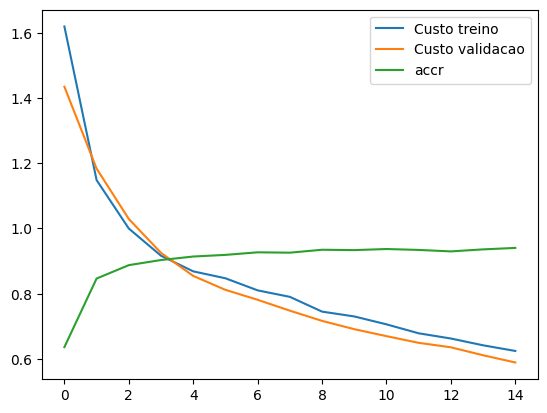

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame()
df['Custo treino'] = history.history['loss']
df['Custo validacao'] = history.history['val_loss']
df['accr'] = history.history['accuracy']

df.plot()
plt.show()

In [20]:
def predicao(X_test, Y_test, model):


    # Prever as probabilidades para as classes
    y_pred_prob = model.predict(X_test)
    


    # Converter as probabilidades para as classes previstas
    y_pred = y_pred_prob.argmax(axis=1)
    
    # Verifica o shape das classes previstas
    print(f"Shape de y_pred: {y_pred.shape}")

    # Gerar o relatório de desempenho
    desempenho = classification_report(Y_test, y_pred)

    # Calcular o AUC
    auc_score = roc_auc_score(Y_test, y_pred_prob, multi_class='ovr')

    return y_pred, desempenho, auc_score
y_pred, desempenho, auc_score = predicao(X_test_array, Y_test, model)

print(desempenho)
print(f"AUC: {auc_score:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step
Shape de y_pred: (557,)
              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.82      0.95      0.88       118
           2       0.00      0.00      0.00        18
           3       0.98      0.99      0.99       414

    accuracy                           0.94       557
   macro avg       0.70      0.56      0.58       557
weighted avg       0.92      0.94      0.93       557

AUC: 0.9775


c:\Users\vitor\OneDrive\Documentos\Faculdade\inteligencia artificial\af_inteligencia_artificial\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vitor\OneDrive\Documentos\Faculdade\inteligencia artificial\af_inteligencia_artificial\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vitor\OneDrive\Documentos\Faculdade\inteligencia artificial\af_inteligencia_artificial\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined

In [21]:
%pip install tf-keras

  Obtaining dependency information for tf-keras from https://files.pythonhosted.org/packages/75/aa/cf09f8956d4f276f655b13674e15d8d6015fd832f9689aa9ff2a515781ab/tf_keras-2.16.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
    --------------------------------------- 0.0/1.7 MB 262.6 kB/s eta 0:00:07
   - -------------------------------------- 0.1/1.7 MB 469.7 kB/s eta 0:00:04
   ---------------------- ----------------- 1.0/1.7 MB 5.2 MB/s eta 0:00:01
   ---------------------------------------  1.7/1.7 MB 7.8 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 6.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Definindo importação do modelo bert pré- treinado

In [22]:
from transformers import BertTokenizer, TFBertModel

# Carregar o tokenizer e o modelo BERT pré-treinado em português
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
bert_model = TFBertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')


c:\Users\vitor\OneDrive\Documentos\Faculdade\inteligencia artificial\af_inteligencia_artificial\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Error while downloading from https://cdn-lfs.huggingface.co/neuralmind/bert-base-portuguese-cased/934cefcc094555ce1d9493ccdc9bd052c9eb5e66a156fb0c630d0b653ce0185d?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27tf_model.h5%3B+filename%3D%22tf_model.h5%22%3B&Expires=1718311791&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxODMxMTc5MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9uZXVyYWxtaW5kL2JlcnQtYmFzZS1wb3J0dWd1ZXNlLWNhc2VkLzkzNGNlZmNjMDk0NTU1Y2UxZDk0OTNjY2RjOWJkMDUyYzllYjVlNjZhMTU2ZmIwYzYzMGQwYjY1M2NlMDE4NWQ%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Signature=oHYGq8jmhN0QyFax46Am%7EOc7vzkf0WZ3bBmTdLMWaQzZJgFShAXSyLQ3g9ApwGmNHQQSpI0k%7ENuVKN9o7dpKplGzMWEVpupmi33hNHIJlpaAqCMwIuNsjap3WMExcnINnEGwKSq-ZQ5lk5kdxVIeMHoav0bqZ0D0B9wLGEHU8ArWhllEzLV8I-%7Eg425GdW%7EiQ28BPbU8xBHMwsqqACn%7EQcF%7E9R-eA8sUL-ZzA6DTPFlXvwKxcw9HZfNHR2W6yBTQ1PctD9Xo2B9EkS%7EscAs2WGG9-iTJO1lv89i5o3Fd90Tk7cQNr6cqYNKxruJ%7EohNH0IML10cdo-VB4

Some layers from the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###  Obtenção das Embeddings BERT
Utilizamos o modelo BERT pré-treinado para obter as embeddings dos textos codificados. A função `get_embeddings_in_batches` processa os textos em lotes para obter as embeddings de forma mais eficiente.

- **input_ids**: IDs dos tokens codificados.
- **attention_mask**: Máscara de atenção para os tokens.
- **model**: Modelo BERT pré-treinado.
- **batch_size**: Tamanho dos lotes para processamento.



In [23]:
def encode_texts(texts, tokenizer, max_length=200):
    inputs = tokenizer(texts, return_tensors='tf', max_length=max_length, truncation=True, padding=True)
    return inputs['input_ids'], inputs['attention_mask']

X_train_encodings, X_train_masks = encode_texts(X_train.tolist(), tokenizer)
X_test_encodings, X_test_masks = encode_texts(X_test.tolist(), tokenizer)


In [24]:
import tensorflow as tf
# Função para obter embeddings em lotes
def get_embeddings_in_batches(input_ids, attention_mask, model, batch_size=32):
    num_samples = input_ids.shape[0]
    embeddings = []
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        batch_input_ids = input_ids[start:end]
        batch_attention_mask = attention_mask[start:end]
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        embeddings.append(outputs.last_hidden_state)
    return tf.concat(embeddings, axis=0)


# Obter os embeddings BERT dos textos codificados

In [25]:
X_train_embeddings = get_embeddings_in_batches(X_train_encodings, X_train_masks, bert_model, batch_size=32)
X_test_embeddings = get_embeddings_in_batches(X_test_encodings, X_test_masks, bert_model, batch_size=32)
print("Dimensao de X_train_embeddings: ", X_train_embeddings.shape)
print("Dimensao de X_test_embeddings: ", X_test_embeddings.shape)

### Configuração do Modelo LSTM
Configuramos um modelo LSTM com uma camada intermediária LSTM e uma camada de saída Dense com ativação softmax. O modelo é compilado usando o otimizador Adam e a função de perda `sparse_categorical_crossentropy`.

- **input_shape**: Forma da entrada para o modelo (dimensões das embeddings criadas com BERT).
- **units**: Número de unidades na camada LSTM.
- **activation**: Função de ativação da camada Dense de saída.

In [ ]:


# Define a dimensão de entrada
embedding_dim = X_train_embeddings.shape[-1]

# Define a dimensão de entrada
input_shape = (200, embedding_dim)

# Definir a camada de entrada
input_layer = layers.Input(shape=input_shape)

# Adicionar a camada LSTM bidirecional com menos unidades e sem regularização complexa
x = layers.Bidirectional(layers.LSTM(
    units=64,  # Número de unidades reduzido
    return_sequences=False,
    dropout=0.3,  # Dropout simples
    recurrent_dropout=0.3  # Dropout nas conexões recorrentes
))(input_layer)

# Adicionar a camada de Dropout para evitar overfitting
x = layers.Dropout(0.3)(x)

# Adicionar a camada de saída densa
output_layer = layers.Dense(
    units=4, activation="softmax"
)(x)

# Criar o modelo
model = Model(inputs=input_layer, outputs=output_layer)

# Definir o otimizador com uma taxa de aprendizado inicial reduzida
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0005  # Taxa de aprendizado reduzida
)

# Compilar o modelo
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("LSTM configurada com sucesso")

print(model.summary())

LSTM configurada com sucesso


Model: "functional_166"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 200, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_32                │ (None, 128)            │       426,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 427,012 (1.63 MB)

 Trainable params: 427,012 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(
    X_train_embeddings, 
    Y_train,
    epochs=5, 
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 291ms/step - accuracy: 0.7794 - loss: 0.6637 - val_accuracy: 0.9191 - val_loss: 0.2818
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 269ms/step - accuracy: 0.9029 - loss: 0.3263 - val_accuracy: 0.9169 - val_loss: 0.2697
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 311ms/step - accuracy: 0.9169 - loss: 0.2495 - val_accuracy: 0.9236 - val_loss: 0.2414
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.9359 - loss: 0.2115 - val_accuracy: 0.9258 - val_loss: 0.2267
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 288ms/step - accuracy: 0.9432 - loss: 0.1616 - val_accuracy: 0.9236 - val_loss: 0.2877


### Avaliação do Modelo
A função `predicao` prevê as probabilidades para as classes, gera o relatório de desempenho e calcula o AUC. O desempenho do modelo é avaliado no conjunto de teste.

- **X_test**: Embeddings BERT dos textos de teste.
- **Y_test**: Labels dos textos de teste.
- **model**: Modelo treinado.

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

def predicao(X_test, Y_test, model):
    # Prever as probabilidades para as classes
    y_pred_prob = model.predict(X_test)

    # Converter as probabilidades para as classes previstas
    y_pred = y_pred_prob.argmax(axis=1)

    # Gerar o relatório de desempenho
    desempenho = classification_report(Y_test, y_pred)

    # Calcular o AUC
    auc_score = roc_auc_score(Y_test, y_pred_prob, multi_class='ovr')

    return y_pred, desempenho, auc_score

##########################################################################

y_pred, desempenho, auc_score = predicao(X_test_embeddings, Y_test, model)

print(desempenho)
print(f"AUC: {auc_score:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.79      0.96      0.87       118
           2       0.00      0.00      0.00        18
           3       0.99      0.99      0.99       414

    accuracy                           0.94       557
   macro avg       0.44      0.49      0.46       557
weighted avg       0.90      0.94      0.92       557

AUC: 0.9718


c:\Users\18340\conda\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\18340\conda\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\18340\conda\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


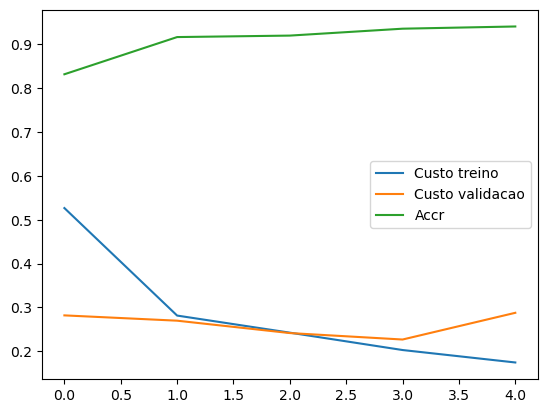

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame()
df['Custo treino'] = history.history['loss']
df['Custo validacao'] = history.history['val_loss']
df['Accr'] = history.history['accuracy']

df.plot()
plt.show()

Instalando bibliotecas para busca de hiperparâmetros. Inicialmente tentamos buscar por meio do algorítmo genético mas optamos por não utiliza-lo devido ao custo computacional (muita demora)

In [ ]:
%pip install keras-tuner
%pip install deap


   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ---------------------------- ----------- 92.2/129.1 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 129.1/129.1 kB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.1 MB 660.6 kB/s eta 0:00:02
     -------- ------------------------------- 0.2/1.1 MB 2.2 MB/s eta 0:00:01
     ----------------------- ---------------- 0.6/1.1 MB 5.0 MB/s eta 0:00:01
     ---------------------------------------  1.1/1.1 MB 6.8 MB/s eta 0:00:01
     ---------------------------------------- 1.1/1.1 MB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for deap: filename=deap-1.4.1-cp311-cp311-win_amd64.whl size=108329 sha256=8c10135bac5e94ef6369463d1344bb737f3fadbd89b6f06ec47f49dc51483968
  Stored in directory: c:\users\18340\appdata\lo

# Construção do Modelo para Keras Tuner
Definimos a função `build_model` para construir o modelo com hiperparâmetros variáveis. O Keras Tuner será usado para encontrar os melhores hiperparâmetros para o modelo.

- **hp**: Hiperparâmetros a serem ajustados.
- **input_shape**: Forma da entrada para o modelo.
- **units**: Número de unidades na camada LSTM.
- **dropout**: Taxa de dropout para a camada Dropout.
- **learning_rate**: Taxa de aprendizado para o otimizador Adam.

In [ ]:
import kerastuner as kt
from tensorflow.keras import layers, Model

def build_model(hp):
    input_shape = X_train_embeddings.shape[1:]
    
    input_layer = layers.Input(shape=input_shape)
    lstm_layer = layers.Bidirectional(
        layers.LSTM(
            units=hp.Int('units', min_value=128, max_value=512, step=64),
            return_sequences=False,
            dropout=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1),
            recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.1, max_value=0.5, step=0.1)
        )
    )(input_layer)
    
    dropout_layer = layers.Dropout(
        rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    )(lstm_layer)
    
    output_layer = layers.Dense(4, activation='softmax')(dropout_layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    )
    
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model


C:\Users\18340\AppData\Local\Temp\ipykernel_7184\2511099339.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


## Configuração e Execução do Keras Tuner
Configuramos o `RandomSearch` do Keras Tuner para realizar a busca pelos melhores hiperparâmetros. Definimos a função de callback `AUCReporter` para monitorar o AUC durante o treinamento.

- **tuner**: Objeto Keras Tuner configurado para busca de hiperparâmetros.
- **epochs**: Número de épocas para cada execução.
- **validation_split**: Proporção dos dados de treino usados para validação.
- **callbacks**: Lista de callbacks a serem usados durante o treinamento.

In [ ]:
def build_model(hp):
    input_shape = X_train_embeddings.shape[1:]
    
    input_layer = layers.Input(shape=input_shape)
    lstm_layer = layers.Bidirectional(
        layers.LSTM(
            units=hp.Int('units', min_value=128, max_value=512, step=64),
            return_sequences=False,
            dropout=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1),
            recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.1, max_value=0.5, step=0.1)
        )
    )(input_layer)
    
    dropout_layer = layers.Dropout(
        rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    )(lstm_layer)
    
    output_layer = layers.Dense(4, activation='softmax')(dropout_layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    )
    
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model

# Configuração do RandomSearch do Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Número de combinações de hiperparâmetros para tentar
    executions_per_trial=1,  # Número de execuções para cada combinação
    directory='keras_tuner_dir',
    project_name='bert_lstm_tuning'
)

# Callback para parar o treinamento quando a métrica monitorada parar de melhorar
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3,  # Parar se não houver melhora em 3 épocas consecutivas
    restore_best_weights=True
)

###  Treinamento do Modelo com os Melhores Hiperparâmetros
Treinamos o modelo com os melhores hiperparâmetros encontrados pelo Keras Tuner.

- **best_hyperparameters**: Melhores hiperparâmetros encontrados pelo Keras Tuner.
- **epochs**: Número de épocas de treinamento.

### Treinando modelo
 O treinamento está sendo feito com 7 épocas, em seguida o melhor modelo será treinado com mais épocas

In [ ]:
tuner.search(
    X_train_embeddings, Y_train,
    epochs=7,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stopping]
)
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hyperparameters)

Trial 10 Complete [00h 13m 52s]
val_accuracy: 0.932584285736084

Best val_accuracy So Far: 0.9483146071434021
Total elapsed time: 02h 31m 06s


In [ ]:
history = best_model.fit(
    X_train_embeddings, Y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.7505 - loss: 0.7092 - val_accuracy: 0.9101 - val_loss: 0.2632
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - accuracy: 0.9045 - loss: 0.3017 - val_accuracy: 0.9236 - val_loss: 0.2242
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step - accuracy: 0.9285 - loss: 0.2079 - val_accuracy: 0.9236 - val_loss: 0.2148
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.9415 - loss: 0.1803 - val_accuracy: 0.9371 - val_loss: 0.2104
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.9453 - loss: 0.1721 - val_accuracy: 0.9371 - val_loss: 0.1908
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.9522 - loss: 0.1419 - val_accuracy: 0.9483 - val_loss: 0.1688
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.9501 - loss: 0.1442 - val_accuracy: 0.9438 - val_loss: 0.1757
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.9481 - loss: 0.1408 - val_accuracy: 0.9281 - v

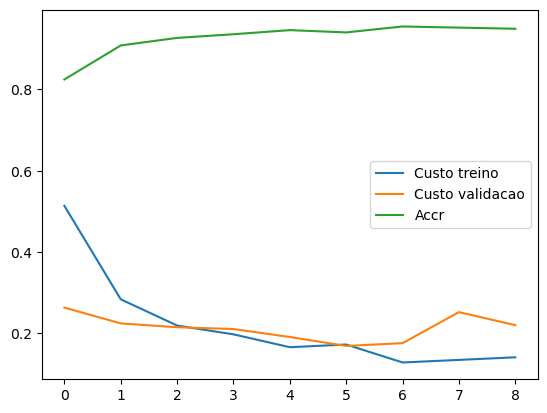

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame()
df['Custo treino'] = history.history['loss']
df['Custo validacao'] = history.history['val_loss']
df['Accr'] = history.history['accuracy']

df.plot()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

def predicao(X_test, Y_test, model):
    # Prever as probabilidades para as classes
    y_pred_prob = model.predict(X_test)

    # Converter as probabilidades para as classes previstas
    y_pred = y_pred_prob.argmax(axis=1)

    # Gerar o relatório de desempenho
    desempenho = classification_report(Y_test, y_pred)

    # Calcular o AUC
    auc_score = roc_auc_score(Y_test, y_pred_prob, multi_class='ovr')

    return y_pred, desempenho, auc_score


y_pred, desempenho, auc_score = predicao(X_test_embeddings, Y_test, best_model)

print(desempenho)
print(f"AUC: {auc_score:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 772ms/step
              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.89      0.90      0.89       118
           2       0.58      0.61      0.59        18
           3       0.99      0.99      0.99       414

    accuracy                           0.95       557
   macro avg       0.86      0.73      0.77       557
weighted avg       0.95      0.95      0.95       557

AUC: 0.9857


In [ ]:
import numpy as np
import pandas as pd

y_pred_prob = best_model.predict(X_test_embeddings)

# Decodificar as classes
class_labels = le.inverse_transform([0, 1, 2, 3])

# Criar o dataframe de submissão
submission = pd.DataFrame(y_pred_prob, columns=class_labels)
submission.insert(0, 'ID', df_test['ID'])

# Salvar o dataframe no arquivo CSV
path_submission = criar_diretorios('submission_files/lst/')
output_file = path_submission + 'lstmBidirecionalSubmission.csv'
submission.to_csv(output_file, index=False, float_format='%.5f')
print(f"Submissão salva em {output_file}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 715ms/step
Submissão salva em lstmBidirecionalSubmission.csv
